# Cross validation

Batchflow allows to perform cross validation. By the `cv_split` method of `Dataset` one can divide dataset into folds and then realize arbitrary logic. Additional functional of `Research` allows to to perform the simplest variant of cross validation.

In [1]:
import sys
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../..")
from batchflow import Pipeline, Dataset, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7
from batchflow.research import Research, Option

To split dataset into `n` folds one just need call `cv_split` method and define `n_splits`:

In [2]:
dset = Dataset(10)
dset.cv_split(n_splits=4)
dset.cv0.train.indices, dset.cv0.test.indices

(array([3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2]))

## Cross validation in `Research`

One can implement cross validation to estimate the quality of the model in the following way.

In [3]:
BATCH_SIZE=64

Define model config.

In [4]:
model_config={
    'session/config': tf.ConfigProto(allow_soft_placement=True),
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': 'cna',
    'device': C('device') # it's technical parameter for TFModel
}

Define dataset that will be used in the training procedure. We take training part of the MNIST dataset to use it for CV.

In [5]:
mnist = MNIST().train

http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Extracting Extracting/tmp/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


Now define main parts of pipelines (without datasets):

In [6]:
train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_variable('accuracy', init_on_each_run=list)
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         fetches='loss', 
                         feed_dict={'images': B('images'), 'labels': B('labels')},
                         save_to=V('loss'), mode='w')
).run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [7]:
test_template = (Pipeline()
            .init_variable('predictions') 
            .init_variable('metrics', init_on_each_run=None) 
            .import_model('conv', C('import_from'))
            .to_array()
            .predict_model('conv', 
                         fetches='predictions', 
                         feed_dict={'images': B('images'), 'labels': B('labels')},
                         save_to=V('predictions'))
            .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics'), mode='a')
).run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)

### Create Research object

Create an instance of `Research` class and add train and test pipelines and grid of parameters:

In [8]:
def get_accuracy(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate('accuracy')

research = (Research()
            .pipeline(train_template, dataset=mnist, fold='train', variables='loss', name='train')
            .pipeline(test_template, dataset=mnist, fold='test', name='test',
                      execute='%10', run=True, import_from='train')
            .function(get_accuracy, returns='accuracy', name='test_accuracy',
                      execute='%10', pipeline='test')

)

Dataset should be added as a separate parameter into research, parameter `fold` describe part of the dataset to use with the pipeline. It means that for dataset `mnist`, pipeline `ppl` and fold `train` for each fold of CV (for example for `cv0`) will be created pipeline `mnist.cv0.train.p + ppl`. 

Method `run` has parameter `cv` which describes the number of folds.

In [9]:
research.run(workers=4, n_iters=200, gpu=[4,5,6,7], cv=3, name='my_research', progress_bar=True)

Research my_research is starting...


  0%|          | 0/600 [00:00<?, ?it/s]

Distributor has 3 jobs with 200 iterations. Totally: 600


100%|██████████| 600/600 [03:41<00:00,  2.71it/s]


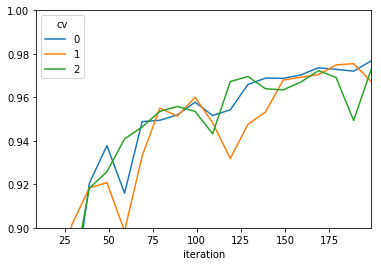

In [10]:
results = research.load_results()

(results[(results.name == 'test_accuracy')]
 .pivot(index='iteration', columns='cv', values='accuracy')
 .plot(ylim=(0.9, 1))
)